In [1]:
# the matrix or data needs to be within the bounds of the linear operator and add suitable noise.
# Input and output should be 2D since we are dealing with images?? 
# A should be a linear function - semidefinite programming - scipy linear operator (make the matrix a linear operator)
# generate the data using the bessel function
# look at reconstructions? 
# photon order
# phase parameter


## Find a matrix that works fir this
## Add the noise to test
## use a proper image
## Convergence test

### Overview

This code performs a convergence analysis using the Chambolle-Pock algorithm with L1-norm data fidelity. The problem being solved involves a forward model for quantum state tomography, which aims to reconstruct the density matrix of a quantum state from measurements. The parameters of the problem, such as the coupling strength (g), the number of measured states (Nrho), and the fidelity function (L1-norm or L2-norm), are set at the beginning of the code.  
 
The Chambolle-Pock algorithm is implemented using a MatrixMult operator created from the forward model matrix, calculated with the function T_mat(). The algorithm is run for a specified number of iterations (niter), and the objective function value and change in rho over time are plotted.  
 
The evaluate() function is used as part of the forward model to solve the problem during the inversion algorithm. The spdiags_py() function imitates the spdiags function in Matlab and creates a sparse band and diagonal matrix. The svec() and smat() functions convert between a Hermitian matrix and a vector. 

The code defines a number of functions used in the inversion algorithm for quantum state tomography. The first few lines import necessary libraries and modules, such as NumPy, h5py, and matplotlib. The functions  `jv`  and  `toeplitz`  are imported from  `scipy.special`  and  `scipy.linalg` , respectively. The  `MatrixMult`  class is imported from the  `pylops`  module.
 The code defines several parameters for the inversion algorithm, including the coupling strength  `g` , the number of states  `N` , and the number of phase values  `Ntheta` . The phase values are generated using the  `np.linspace`  function. The  `besselj`  function is defined as an alias for  `jv` .
 The  `bess_mats`  dictionary is then defined to store Bessel matrices for different values of  `m` . The  `for`  loop constructs each Bessel matrix as a product of two Toeplitz matrices of Bessel functions. These matrices are then stored in the  `bess_mats`  dictionary.
 Next, the Fourier transform matrix  `FT`  is defined using  `np.exp`  and reshaped using  `numpy.reshape` .
 The function  `spdiags_py`  imitates the  `spdiags`  function in MATLAB. It takes a matrix  `A`  and a list  `k`  as arguments and returns a sparse matrix with the given diagonals. The function  `svec`  converts a Hermitian matrix  `A`  into a vector  `v` . The function  `smat`  is inverse of  `svec` .
 The  `evaluate`  function solves the forward problem during the inversion algorithm. It converts the input vector  `rho_vec`  to a Hermitian matrix  `rho` , creates a sparse band and diagonal matrix of nonzero diagonals, and returns the output of the forward problem as a vector.
 The  `T_mat`  function returns a matrix  `T`  for use in the inversion algorithm. It iterates over all indices of a matrix of size  `matSize`  and calls  `evaluate`  with a vector having a 1 at that index and zeros elsewhere. The output of  `evaluate`  for each vector is stored as a column of  `T` .

 The "chambolle_pock_convergence" function takes in a vector "rho_vec" and several optional parameters such as a function "data_fidelity" (which by default is set to the L1 data fidelity function), the number of iterations "niter", the value of "tau", "sigma", and "theta".
 First, the function creates a copy of "rho_vec" and initializes the forward model matrix "T" using the "T_mat" function. It then creates a MatrixMult operator using the MatrixMult class and passes in the forward model matrix "T".
 The function then initializes empty lists to hold the objective function values and the change in "rho" values over time.
 The function then performs Chambolle-Pock iterations for "niter" times. In each iteration, it evaluates "rho" and "rho_dual" using the "evaluate" function, subtracts the data fidelity term (using either L1 or L2 data fidelity function), and updates "rho_new" using the "H" operator (conjugate of "T") and the "sigma" value.
 Finally, the new "rho" value is updated using the "theta" value and the previous "rho" value. The objective function value and the change in "rho" values are appended to their respective lists, and the new "rho" value is assigned to "rho".
 The function returns the final "rho" value, the objective function values over time, and the change in "rho" values over time.
-  rho_vec :  rho_vec  is the input parameter that determines the initial values for the autoregressive parameter  rho  used in the VAR model. It is updated iteratively during the Chambolle-Pock algorithm to obtain an estimate of  rho  that minimizes the data fidelity term. 
-  T_mat() :  T_mat()  is the function that returns the matrix of time series observations that is used to estimate the VAR model parameters, including  rho . The forward model matrix  T  is calculated from  T_mat()  and is used to create a  MatrixMult  operator. The  MatrixMult  operator is then used to calculate the prediction error, which is used in the data fidelity term during the Chambolle-Pock iterations. 
Thus,  rho_vec  is an input parameter that determines the initial values of  rho , while  T_mat()  is a function that returns the time series observations used to estimate the VAR model parameters. Both  rho_vec  and  T_mat()  are used in the implementation of the Chambolle-Pock algorithm to iteratively estimate  rho  that best fits the data.

In [2]:
!pip3 install pylops

  Using cached pylops-2.1.0-py3-none-any.whl (275 kB)


In [3]:
import numpy as np
import h5py
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
from scipy.special import jv
from scipy.linalg import toeplitz
import scipy.io
import numpy as np
from pylops import MatrixMult


besselj = jv

# set parameters
g = 100 # parameter g describing coupling strength
g_known = True 
N = 4 # must be even 
Nrho = N # number of highest measured state: N may be different from Nrho!
Ntheta = 100  # e.g. =100 number of the highest occupied state represented in rho
theta = np.linspace(0,2*np.pi,Ntheta) # vector of phase values

bess_mats = {}   
for m in range(-N,N+1):
    aux = toeplitz(besselj(range(2*N+1),2*g),besselj(range(0,-2*N-1,-1),2*g)) \
     *toeplitz(besselj(range(2*m,2*(N+m)+1),2*g),besselj(range(2*m,2*(-N+m)-1,-1),2*g))
    bess_mats[m+N] = aux[:,::2]

FT = np.exp(-2j*np.arange(-N,N+1).reshape((-1,1))*theta.reshape((1,-1)))

Lind = np.tril_indices(Nrho+1,-1)


def spdiags_py(A,k):
    """
    Function imitating the spdiags function in matlab
    Example:
    >>> A = np.array([[1,2,3],[4,5,6],[7,8,9]])
    >>> spdiags_py(A,range(-2,3))
    array([[7, 4, 1, 0, 0],
           [0, 8, 5, 2, 0],
           [0, 0, 9, 6, 3]])
    """
    ret = []
    for i in k:
        ret += [[0] * max(0,i) + list(np.diag(A,i)) + [0] * max(0,-i)]
    return np.array(ret).T


def svec(A):
    """ converts a hermitian matrix A into a vector v such that
    ||v||_2 = ||A||_Frobenius """

    N = A.shape[0] # = Nrho
    v = np.zeros((N+1)**2)
    v[:N*(N+1)//2] = np.sqrt(2)*np.real(A[Lind])
    v[N*(N+1)//2:N*(N+1)] = np.sqrt(2)*np.imag(A[Lind])
    v[N*(N+1):] = np.real(np.diag(A))
    return v
    
    
def smat(v):
    """ converts a vector v into a hermitian matrix A: inverse of svec """
    N = int(len(v)**0.5)-1 # = Nrho
    A = np.zeros((N+1,N+1),dtype=np.complex64)
    A[Lind] = 1/np.sqrt(2)*(v[:N*(N+1)//2] + 1j*v[N*(N+1)//2:N*(N+1)])
    return A + A.T + np.diag(v[N*(N+1):])



def evaluate(rho_vec):
    """ routine for the solution of the forward problem during the inversion algorithm
    (corresponds to ForwardProblem.m:l.139)"""
    if N == Nrho:
        rho = smat(rho_vec) # we convert the vector we have to a Hermitian Matrix
    else:
        rho = np.zeros((N+1,N+1))
        a = (N-Nrho)//2
        b = a +Nrho+1
        rho[a:b,a:b] = smat(rho_vec)  
        
    # We Extract nonzero diagonals and create sparse band and diagonal matrices    
    rho_diags  = spdiags_py(rho.T,range(-N,N+1))
    
    Itilde = np.zeros((2*N+1,2*N+1),dtype=np.complex64)
    
    # Create Toeplitz matrix (The diagonal)
    for m in range(-N,N+1):
        if not g_known:
            aux = toeplitz(besselj(range(2*N+1),2*g),besselj(range(0,-2*N-1,-1),2*g)) \
                 * toeplitz(besselj(range(2*m,2*(N+m)+1),2*g),besselj(range(2*m,2*(-N+m)-1,-1),2*g))
            bess_mats[m+N] = aux[:,::2]
        Itilde[:,m+N] = bess_mats[m+N]@rho_diags[:,m+N] # bessel matrix * the non-zero diagonals
    Ix = np.real(Itilde@FT) # Multiply it by the fourier transform matrix
    return Ix.reshape(-1);


# density matrix
def T_mat():
    """
    (corresponds to ForwardProblem.m:l.165)
    
    """
    matSize = Nrho+1;
    T = np.zeros(((2*N+1)*Ntheta,matSize**2));
    for cntr in range(matSize**2):
        e = np.zeros(matSize**2)
        e[cntr] = 1
        T[:,cntr] = evaluate(e)
    return T


In [4]:
T = T_mat()
print(T.shape)

(900, 25)


In [5]:
def l1_data_fidelity(x, y, tau):
  return tau * np.sum(np.abs(x - y))


def l2_data_fidelity(x, y, tau):
  return tau * np.sum(np.linalg.norm(x - y)**2)

In [6]:
def chambolle_pock(rho_vec, data_fidelity=l1_data_fidelity, niter=100, tau=1, sigma=1, theta=1):
    rho = np.copy(rho_vec)
     # Calculate forward model matrix
    T = T_mat()
     # Create MatrixMult operator
    matrix_mult = MatrixMult(T)

     # Perform Chambolle-Pock iterations
    for _ in range(niter):
        evaluate_rho = evaluate(rho)
        evaluate_rho_dual = evaluate_rho - data_fidelity(evaluate_rho, matrix_mult*rho, tau)
        rho = rho - sigma * matrix_mult.H * evaluate_rho_dual
        rho = (1 + theta) * rho - theta * rho
    return rho


def chambolle_pock_convergence(rho_vec, data_fidelity=l1_data_fidelity, niter=100, tau=1, sigma=1, theta=1):
    rho = np.copy(rho_vec)
    # Calculate forward model matrix
    T = T_mat()
    # Create MatrixMult operator
    matrix_mult = MatrixMult(T)

    # Define list to hold objective function values
    obj_vals = []
    # Define list to hold change in rho values over time
    rho_changes = []

    # Perform Chambolle-Pock iterations
    for i in range(niter):
        evaluate_rho = evaluate(rho)
        evaluate_rho_dual = evaluate_rho - data_fidelity(evaluate_rho, matrix_mult*rho, tau)
        rho_new = rho - sigma * matrix_mult.H * evaluate_rho_dual
        rho_new = (1 + theta) * rho_new - theta * rho
        obj_val = evaluate(rho_new) + data_fidelity(evaluate_rho_dual, 0, -tau)
        rho_change = np.linalg.norm(rho_new - rho) / np.linalg.norm(rho)
        # if i % 10 == 0:
        #   print(f"Iteration {i}: Objective value = {obj_val}, Rho change = {rho_change}")
        obj_vals.append(obj_val)
        rho_changes.append(rho_change)
        rho = rho_new
    return rho, obj_vals, rho_changes

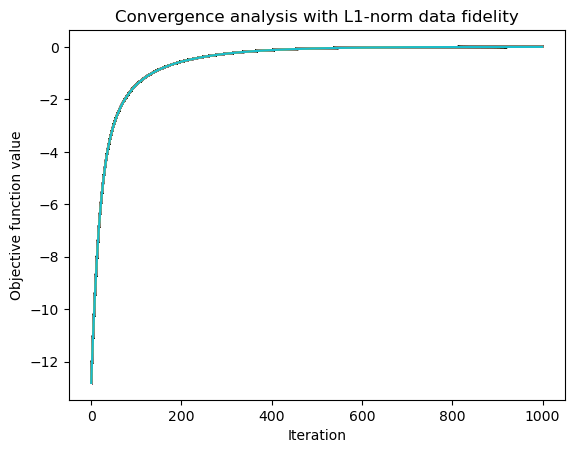

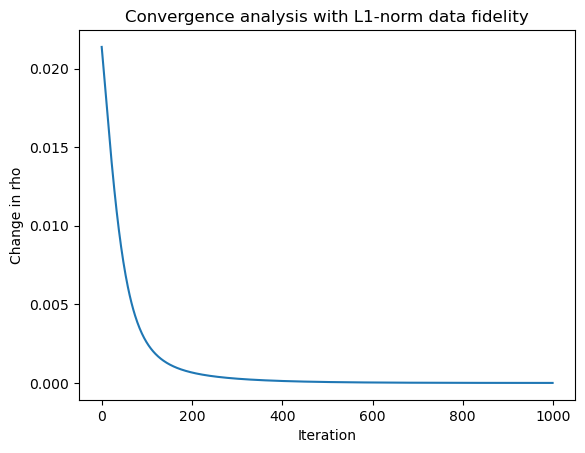

In [7]:
# Perform convergence analysis with L1-norm data fidelity
rho_vec = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
rho_vec = np.ones(25)
rho_l1, obj_vals_l1, rho_changes_l1 = chambolle_pock_convergence(rho_vec, data_fidelity=l1_data_fidelity, niter=1000, tau=2.0, sigma=1.0, theta=1.0)

# Plot objective function value over time
fig, ax = plt.subplots()
ax.plot(range(len(obj_vals_l1)), obj_vals_l1)
ax.set_xlabel('Iteration')
ax.set_ylabel('Objective function value')
ax.set_title('Convergence analysis with L1-norm data fidelity')
plt.show()

# Plot change in rho over time
fig, ax = plt.subplots()
ax.plot(range(len(rho_changes_l1)), rho_changes_l1)
ax.set_xlabel('Iteration')
ax.set_ylabel('Change in rho')
ax.set_title('Convergence analysis with L1-norm data fidelity')
plt.show()

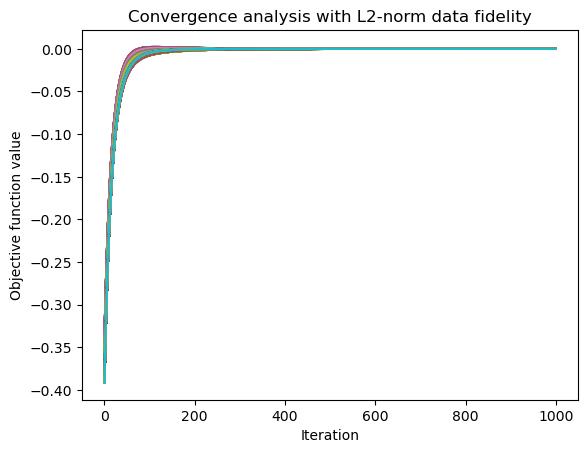

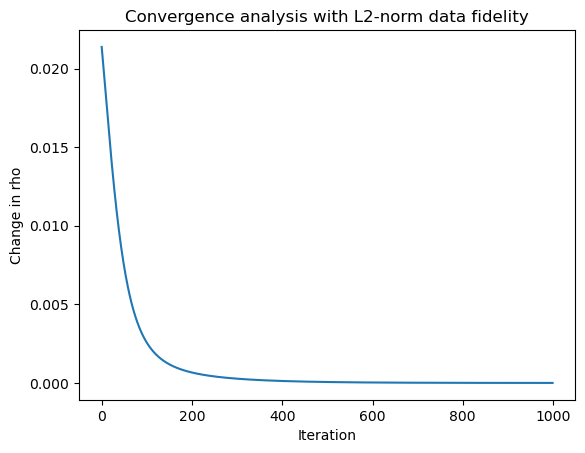

In [8]:
# Perform convergence analysis with L2-norm data fidelity
rho_l2, obj_vals_l2, rho_changes_l2 = chambolle_pock_convergence(rho_vec, data_fidelity=l2_data_fidelity, niter=1000, tau=2.0, sigma=1.0, theta=1.0)

# Plot objective function value over time
fig, ax = plt.subplots()
ax.plot(range(len(obj_vals_l2)), obj_vals_l2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Objective function value')
ax.set_title('Convergence analysis with L2-norm data fidelity')
plt.show()

# Plot change in rho over time
fig, ax = plt.subplots()
ax.plot(range(len(rho_changes_l2)), rho_changes_l2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Change in rho')
ax.set_title('Convergence analysis with L2-norm data fidelity')
plt.show()